# **Tugas Final Project: Sistem Rekomendasi Anime dengan Clustering**
**Nama:** Abdi Wicaksono B.S

**NIM:** 23.11.5617

**Kelas:** IF04


## **1. Import Library**
Langkah pertama adalah mengimport library yang dibutuhkan untuk pengolahan data dan pemodelan.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Setting visualisasi
sns.set(style="whitegrid")
%matplotlib inline

## **2. Load Dataset**
Kita akan memuat dua dataset: `anime.csv` (informasi anime) dan `rating.csv` (rating user).
Pastikan file sudah diupload ke Google Colab.

In [6]:
# Load data
anime_df = pd.read_csv('/content/drive/MyDrive/Semester 5/Big Data Mining/UAS/anime.csv')
rating_df = pd.read_csv('/content/drive/MyDrive/Semester 5/Big Data Mining/UAS/rating.csv')

# Menampilkan sample data
print("Info Dataset Anime:")
display(anime_df.head())
print("\nInfo Dataset Rating:")
display(rating_df.head())

Info Dataset Anime:


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266



Info Dataset Rating:


,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


## **3. Data Cleaning & Preprocessing**
Kita perlu membersihkan data, terutama menangani *missing values* dan memformat kolom genre agar bisa dihitung.

In [7]:
# Cek missing values
print(anime_df.isnull().sum())

# Drop baris dengan missing values (biasanya sedikit)
anime_df = anime_df.dropna()

# Membersihkan karakter aneh pada nama jika ada
anime_df['name'] = anime_df['name'].apply(lambda x: x.replace('&quot;', ''))

# Mengubah 'type' menjadi kategori numerik (One-Hot Encoding sederhana) atau drop jika fokus genre
# Kita akan fokus pada Genre, Rating, dan Members untuk clustering

# Memisahkan Genre (karena satu anime bisa banyak genre)
# Contoh: "Action, Adventure" -> [1, 1, 0, ...]
anime_df['genre'] = anime_df['genre'].apply(lambda x: x.split(', '))

# Menggunakan MultiLabelBinarizer untuk genre
mlb = MultiLabelBinarizer()
genre_encoded = pd.DataFrame(mlb.fit_transform(anime_df['genre']), columns=mlb.classes_, index=anime_df.index)

# Gabungkan kembali dengan dataframe utama (Rating dan Members)
anime_features = pd.concat([anime_df[['rating', 'members']], genre_encoded], axis=1)

display(anime_features.head())

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64


,rating,members,Action,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire,Yaoi,Yuri
0,9.37,200630,0,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,9.26,793665,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,9.25,114262,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9.17,673572,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9.16,151266,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Visualisasi

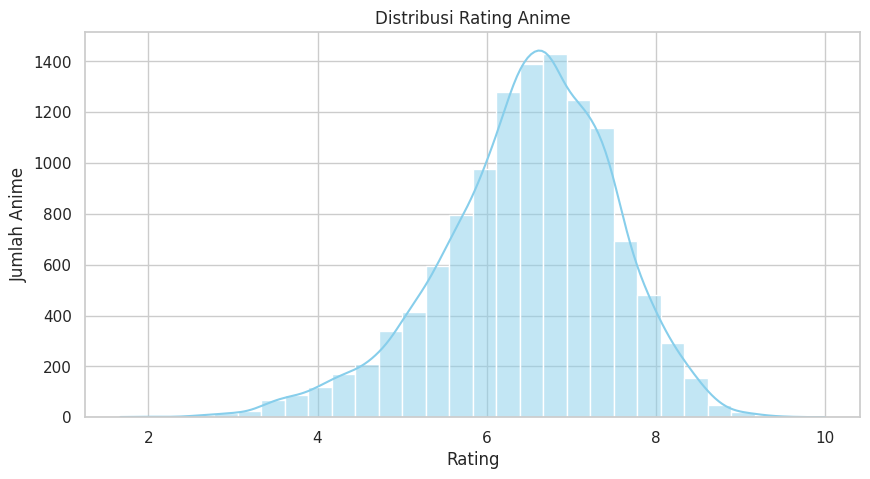

/tmp/ipython-input-4288394270.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')


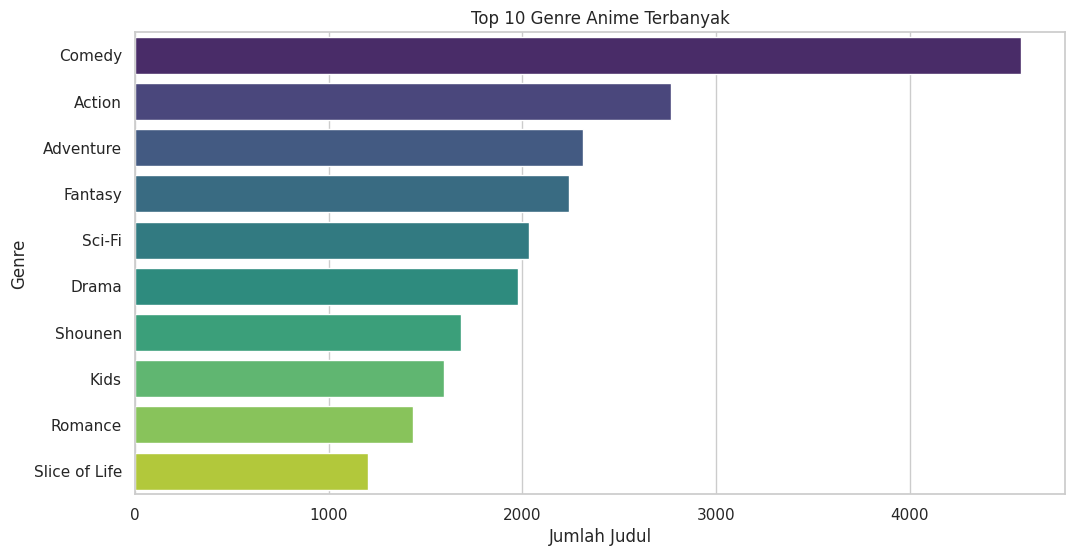

In [17]:
# 1. Visualisasi Distribusi Rating
plt.figure(figsize=(10, 5))
sns.histplot(anime_df['rating'].dropna(), bins=30, kde=True, color='skyblue')
plt.title('Distribusi Rating Anime')
plt.xlabel('Rating')
plt.ylabel('Jumlah Anime')
plt.show()

# 2. Visualisasi 10 Genre Terpopuler
# Menjumlahkan kolom genre hasil One-Hot Encoding
genre_counts = genre_encoded.sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='viridis')
plt.title('Top 10 Genre Anime Terbanyak')
plt.xlabel('Jumlah Judul')
plt.ylabel('Genre')
plt.show()

## **4. Feature Scaling**
Karena range `members` (ribuan/jutaan) dan `rating` (1-10) sangat berbeda, kita perlu melakukan scaling agar K-Means bekerja optimal.

In [8]:
scaler = StandardScaler()
anime_scaled = scaler.fit_transform(anime_features)

print("Data setelah scaling:")
print(anime_scaled[:2])

Data setelah scaling:
[[ 2.82447359  3.2920442  -0.54706087 -0.48860851 -0.07763779 -0.78406256
  -0.14214588 -0.15641988  2.25353092 -0.23482105 -0.47891608 -0.12226743
  -0.16353285 -0.32264184 -0.26670083 -0.17623743 -0.06592427 -0.39162947
  -0.25745323 -0.14987445 -0.28945513 -0.18936467 -0.27449364 -0.20507775
  -0.18627802 -0.12843158 -0.13844552  2.71340393 -0.11090031  3.03620444
  -0.45164984 -0.21522381 -0.22803585 -0.0671857  -0.40355974 -0.07201468
  -0.33368766 -0.17996754 -0.21543537 -0.19746798  3.31737773 -0.08490061
  -0.09160444 -0.05632245 -0.0585108 ]
 [ 2.7170322  14.00240972  1.82795015  2.0466283  -0.07763779 -0.78406256
  -0.14214588 -0.15641988  2.25353092 -0.23482105  2.08804849 -0.12226743
  -0.16353285 -0.32264184 -0.26670083 -0.17623743 -0.06592427 -0.39162947
   3.88420065 -0.14987445 -0.28945513  5.28081615 -0.27449364 -0.20507775
  -0.18627802 -0.12843158 -0.13844552 -0.36854078 -0.11090031 -0.32935859
  -0.45164984 -0.21522381 -0.22803585 -0.0671857   

## **5. Menentukan Jumlah Cluster (Elbow Method)**
Kita menggunakan metode Elbow untuk mencari jumlah cluster (k) yang paling optimal.

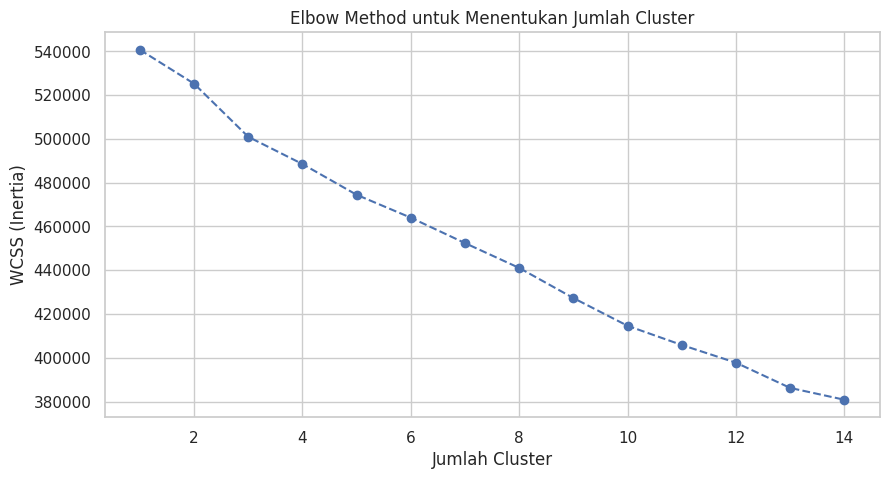

In [9]:
wcss = []
range_k = range(1, 15) # Mencoba k dari 1 sampai 14

for i in range_k:
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(anime_scaled)
    wcss.append(kmeans.inertia_)

# Plotting Elbow Graph
plt.figure(figsize=(10,5))
plt.plot(range_k, wcss, marker='o', linestyle='--')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster')
plt.ylabel('WCSS (Inertia)')
plt.show()

## **6. Modeling: K-Means Clustering**
Berdasarkan grafik Elbow di atas, kita pilih jumlah cluster yang tekukannya paling tajam (misal k=10 atau sesuai grafik nanti).

In [10]:
# Misalkan kita pilih k=10 berdasarkan elbow
k_optimal = 10
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(anime_scaled)

# Masukkan hasil cluster ke dataframe asli
anime_df['cluster'] = clusters

display(anime_df[['name', 'genre', 'rating', 'cluster']].head(10))

,name,genre,rating,cluster
0,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",9.37,0
1,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",9.26,1
2,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",9.25,8
3,Steins;Gate,"[Sci-Fi, Thriller]",9.17,4
4,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",9.16,8
5,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"[Comedy, Drama, School, Shounen, Sports]",9.15,2
6,Hunter x Hunter (2011),"[Action, Adventure, Shounen, Super Power]",9.13,6
7,Ginga Eiyuu Densetsu,"[Drama, Military, Sci-Fi, Space]",9.11,1
8,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"[Action, Comedy, Historical, Parody, Samurai, ...",9.10,8
9,Gintama&#039;: Enchousen,"[Action, Comedy, Historical, Parody, Samurai, ...",9.11,8


## **7. Visualisasi Cluster (PCA)**
Karena data kita berdimensi tinggi (banyak genre), kita gunakan PCA (Principal Component Analysis) untuk mereduksinya menjadi 2 dimensi agar bisa digambar.

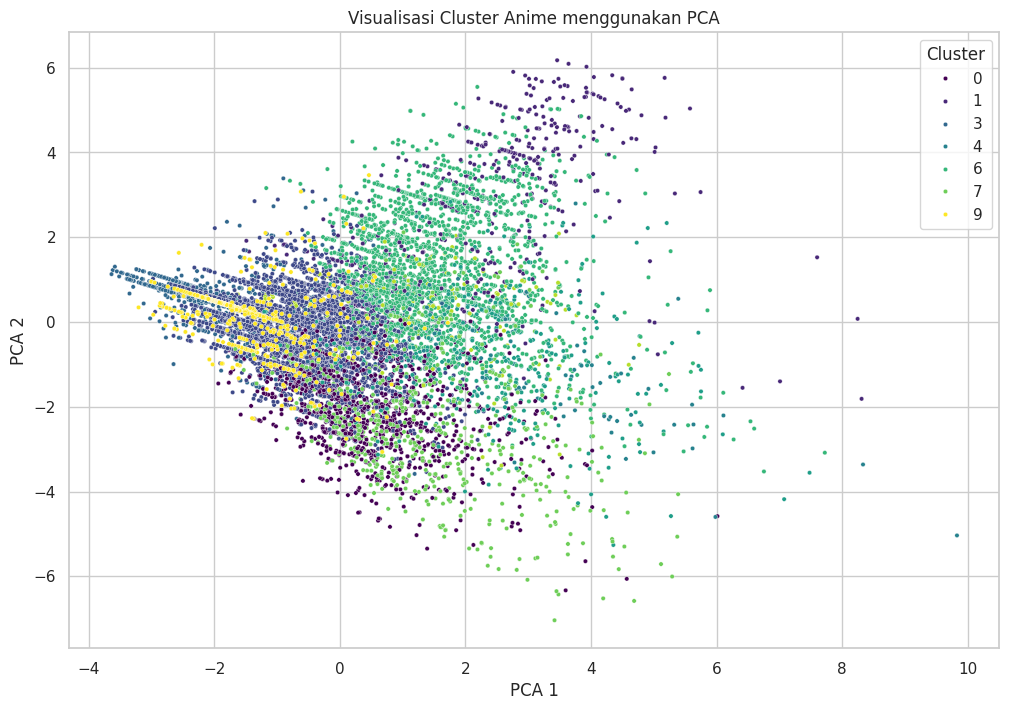

In [11]:
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(anime_scaled)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=reduced_features[:,0], y=reduced_features[:,1], hue=anime_df['cluster'], palette='viridis', s=10)
plt.title('Visualisasi Cluster Anime menggunakan PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

## **8. Evaluasi**

In [14]:
from sklearn.metrics import silhouette_score

# Gunakan 'anime_scaled' sesuai nama variabel di notebook Anda
silhouette_avg = silhouette_score(anime_scaled, kmeans.labels_)

print(f"Silhouette Score untuk {kmeans.n_clusters} cluster adalah: {silhouette_avg:.4f}")

Silhouette Score untuk 10 cluster adalah: 0.0829


## **9. Membuat Fungsi Rekomendasi**
Fungsi ini akan menerima judul anime, mencari clusternya, dan memberikan rekomendasi anime lain yang berada di cluster yang sama.

In [15]:
def get_recommendations(anime_name, df=anime_df):
    # Cari anime berdasarkan nama
    anime = df[df['name'].str.contains(anime_name, case=False, regex=False)]

    if anime.empty:
        return "Anime tidak ditemukan! Coba cek ejaan."

    # Ambil cluster dari anime tersebut
    target_cluster = anime.iloc[0]['cluster']
    found_name = anime.iloc[0]['name']

    print(f"Rekomendasi untuk penikmat: **{found_name}** (Cluster {target_cluster})")

    # Filter anime lain di cluster yang sama, urutkan berdasarkan rating tertinggi
    recommendations = df[df['cluster'] == target_cluster].sort_values(by='rating', ascending=False)

    # Hindari merekomendasikan anime itu sendiri
    recommendations = recommendations[recommendations['name'] != found_name]

    return recommendations[['name', 'genre', 'rating', 'members']].head(10)

# --- PENGUJIAN ---
# Coba cari rekomendasi untuk anime populer, misalnya 'Naruto' atau 'Kimi no Na wa'
get_recommendations('Kimi no Na wa')

Rekomendasi untuk penikmat: **Kimi no Na wa.** (Cluster 0)


,name,genre,rating,members
10,Clannad: After Story,"[Drama, Fantasy, Romance, Slice of Life, Super...",9.06,456749
11,Koe no Katachi,"[Drama, School, Shounen]",9.05,102733
14,Haikyuu!! Second Season,"[Comedy, Drama, School, Shounen, Sports]",8.93,179342
16,Shigatsu wa Kimi no Uso,"[Drama, Music, Romance, School, Shounen]",8.92,416397
30,Great Teacher Onizuka,"[Comedy, Drama, School, Shounen, Slice of Life]",8.77,268487
31,Natsume Yuujinchou Go,"[Drama, Fantasy, Shoujo, Slice of Life, Supern...",8.76,38865
34,Natsume Yuujinchou Shi,"[Drama, Fantasy, Shoujo, Slice of Life, Supern...",8.75,98431
35,Howl no Ugoku Shiro,"[Adventure, Drama, Fantasy, Romance]",8.74,333186
39,Bakuman. 3rd Season,"[Comedy, Drama, Romance, Shounen]",8.71,133620
43,Haikyuu!!,"[Comedy, Drama, School, Shounen, Sports]",8.68,284498


In [16]:
import joblib

# Menyimpan model K-Means yang sudah dilatih
joblib.dump(kmeans, 'kmeans_anime_model.pkl')

# Menyimpan scaler (penting agar data baru bisa diskalakan sama persis)
joblib.dump(scaler, 'scaler_anime.pkl')

print("Model dan Scaler berhasil disimpan!")

Model dan Scaler berhasil disimpan!
